# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 150000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (150000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [10]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(126359, 10)

In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

84.23933333333333

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [14]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(126357, 10)


1    106326
0     20031
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [16]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.
Its about time Spanish products started getting their due.. The most famous (rightly so) Spanish cheese, Manchego, is world class, and is really tough to beat.  Try some with some fig cake, or some quince paste, or drizzled with olive oil garnished with rosemary..  Serve with a fino sherry, manzanilla, or any number of red wines (depending on age of cheese), and you are guaranteed a winning combination..  Sliced, melted over a great burger, with a roasted red pepper and a hearty glass of earthy zinfandel = heavenly joy..  Cube and marinate in Spanish olive oil is also a treat... I have had no problems with iGourmet so far, so I can't comment on their customer service - all of my orders have been shipped quickly (1-3 business days

In [17]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.


In [18]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.
Its about time Spanish products started getting their due.. The most famous (rightly so) Spanish cheese, Manchego, is world class, and is really tough to beat.  Try some with some fig cake, or some quince paste, or drizzled with olive oil garnished with rosemary..  Serve with a fino sherry, manzanilla, or any number of red wines (depending on age of cheese), and you are guaranteed a winning combination..  Sliced, melted over a great burger, with a roasted red pepper and a hearty glass of earthy zinfandel = heavenly joy..  Cube and marinate in Spanish olive oil is also a treat... I have had no problems with iGourmet so far, so I can't comment on their customer service - all of my orders have been shipped quickly (1-3 business days

In [19]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I love this stuff.  I nuke a mug a milk until it is very hot, drop in 2 of the triangles, stir until the chocolate melts, then froth it with my Aerolatte.  Simple and tasty.


In [21]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.


In [22]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I love this stuff I nuke a mug a milk until it is very hot drop in 2 of the triangles stir until the chocolate melts then froth it with my Aerolatte Simple and tasty 


In [23]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 126357/126357 [00:52<00:00, 2414.78it/s]


In [23]:
preprocessed_reviews[1500]

'love stuff nuke mug milk hot drop triangles stir chocolate melts froth aerolatte simple tasty'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [24]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (126357, 66460)
the number of unique words  66460


## [4.2] Bi-Grams and n-Grams.

In [25]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (126357, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [26]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abc', 'abdominal', 'abdominal pain', 'abide', 'abilities']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (126357, 74310)
the number of unique words including both unigrams and bigrams  74310


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 8: Decision Trees

<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 20 important features from both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Decision Trees

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

In [2]:
connect=sqlite3.connect('final.sqlite')


In [3]:
cleaned_data= pd.read_sql_query("select * from cleaned", connect)

In [6]:
cleaned_data.shape

(348260, 12)

In [4]:
cleaned_data['Time'] = pd.to_datetime(cleaned_data['Time'], unit = 's')
cleaned_data= cleaned_data.sort_values(by='Time')

In [5]:
cleaned_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,processed_review
26,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,every book educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
31,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,whole series great way spend time child,I can remember seeing the show when it aired o...,remember seeing show aired television years ag...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02,entertainingl funny,Beetlejuice is a well written movie ..... ever...,beetlejuice well written movie everything exce...
400,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-12-06,modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captured film starring mic...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,2000-01-03,fantastic,Beetlejuice is an excellent and funny movie. K...,beetlejuice excellent funny movie keaton hilar...


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier

In [7]:
X_3k = cleaned_data['processed_review']
Y_3k = cleaned_data['Score']

In [8]:
X= X_3k[0:100000]
Y=Y_3k[0:100000]

In [9]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,shuffle=False)

In [10]:
print("The Shape of train data is :",X_train.shape, Y_train.shape)
print("The Shape of test data is :",X_test.shape, Y_test.shape)


The Shape of train data is : (70000,) (70000,)
The Shape of test data is : (30000,) (30000,)


In [11]:
#We will make the model learn the vocab from train dataset. We will use countvectorizer to serve our purpose
vec= CountVectorizer(min_df = 50)
bow_train = vec.fit_transform(X_train)
bow_test = vec.transform(X_test)



#normalize the data 
from sklearn import preprocessing
bow_train = preprocessing.normalize(bow_train)
bow_test = preprocessing.normalize(bow_test)




In [12]:
print("After Vectorization")
print(bow_train.shape,Y_train.shape)
print(bow_test.shape,Y_test.shape)


After Vectorization
(70000, 4150) (70000,)
(30000, 4150) (30000,)


In [13]:
from sklearn.model_selection import TimeSeriesSplit

dt= DecisionTreeClassifier(class_weight='balanced')
#we will create a dictonary of values using which we will test for n_neighbors
depths=[1, 5, 10, 50, 100, 500, 100]
split=[5, 10, 100, 500]
para_grid= {'max_depth':depths, 'min_samples_split':split}
#We will use the gridsearch to test all aforementioned values for alpha
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
ts_cv = TimeSeriesSplit(n_splits =10)
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
dt_bow= GridSearchCV(dt,para_grid,cv=ts_cv,scoring='roc_auc',n_jobs=-1)
#we will be fitting the optimised k values to the train_bow data
dt_bow.fit(bow_train,Y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [1, 5, 10, 50, 100, 500, 100], 'min_samples_split': [5, 10, 100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [14]:
#The best C value obtained from the gridsearchCV is 
best_para= dt_bow.best_params_
print("Best  Hyperparameter:", best_para)
print("The accuracy obtained by using the hyperparameter is:",dt_bow.best_score_*100)


Best  Hyperparameter: {'max_depth': 50, 'min_samples_split': 500}
The accuracy obtained by using the hyperparameter is: 77.36505850089911


In [15]:
keys = dt_bow.cv_results_['params']

In [16]:
key=[]
for i in keys:
    key.append(str(i))
print(key)

["{'max_depth': 1, 'min_samples_split': 5}", "{'max_depth': 1, 'min_samples_split': 10}", "{'max_depth': 1, 'min_samples_split': 100}", "{'max_depth': 1, 'min_samples_split': 500}", "{'max_depth': 5, 'min_samples_split': 5}", "{'max_depth': 5, 'min_samples_split': 10}", "{'max_depth': 5, 'min_samples_split': 100}", "{'max_depth': 5, 'min_samples_split': 500}", "{'max_depth': 10, 'min_samples_split': 5}", "{'max_depth': 10, 'min_samples_split': 10}", "{'max_depth': 10, 'min_samples_split': 100}", "{'max_depth': 10, 'min_samples_split': 500}", "{'max_depth': 50, 'min_samples_split': 5}", "{'max_depth': 50, 'min_samples_split': 10}", "{'max_depth': 50, 'min_samples_split': 100}", "{'max_depth': 50, 'min_samples_split': 500}", "{'max_depth': 100, 'min_samples_split': 5}", "{'max_depth': 100, 'min_samples_split': 10}", "{'max_depth': 100, 'min_samples_split': 100}", "{'max_depth': 100, 'min_samples_split': 500}", "{'max_depth': 500, 'min_samples_split': 5}", "{'max_depth': 500, 'min_samples

[0.63085448 0.63085448 0.63085448 0.63085448 0.75634978 0.75626261
 0.75508203 0.75138882 0.83984802 0.83716467 0.82774935 0.8127897
 0.97692668 0.97159939 0.94823735 0.91292836 0.99210225 0.98884272
 0.97045791 0.9294248  0.99985261 0.99897141 0.98684122 0.94547979
 0.99209682 0.98878984 0.97055218 0.92968895]


Text(0.5, 1.0, 'Error Plot')

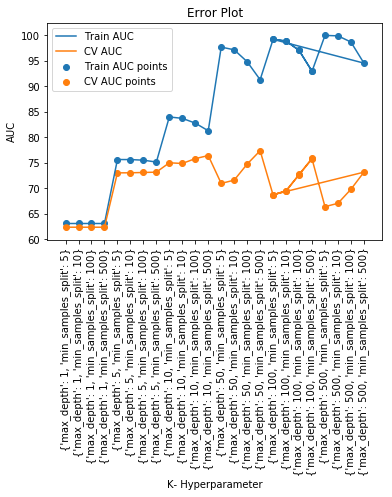

In [17]:
train_auc = dt_bow.cv_results_['mean_train_score']
cv_auc = dt_bow.cv_results_['mean_test_score']
print(train_auc)
plt.plot(key,train_auc*100,label='Train AUC')
plt.plot(key,cv_auc*100,label='CV AUC')
plt.scatter(key,train_auc*100,label='Train AUC points')
plt.scatter(key,cv_auc*100,label='CV AUC points')
plt.xticks(rotation=90)
plt.legend()
plt.xlabel('K- Hyperparameter')
plt.ylabel('AUC')
plt.title('Error Plot')



In [18]:
#we will select the best hyperparameter and train the model using the parameter

dt= DecisionTreeClassifier(max_depth=50,min_samples_split=500,class_weight='balanced')
dt.fit(bow_train, Y_train)
y_train_pred= dt.predict_proba(bow_train)[:,1]
y_test_pred=dt.predict_proba(bow_test)[:,1]

In [19]:
train_fpr,train_tpr,thersholds=roc_curve(Y_train,y_train_pred)
test_fpr,test_tpr,thersholds=roc_curve(Y_test,y_test_pred)

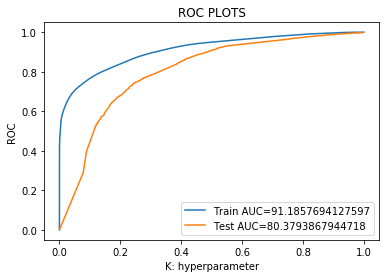

In [20]:
plt.plot(train_fpr,train_tpr,label="Train AUC=" +str(auc(train_fpr,train_tpr)*100))
plt.plot(test_fpr,test_tpr,label="Test AUC=" +str(auc(test_fpr,test_tpr)*100))
plt.xlabel("K: hyperparameter")
plt.ylabel("ROC")
plt.title("ROC PLOTS")
plt.legend()
plt.legend()

Text(33.0, 0.5, 'True Label')

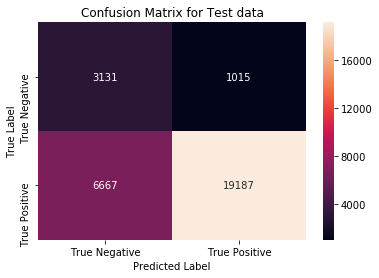

In [21]:
class_label = ["True Negative", "True Positive"]
cm=pd.DataFrame(confusion_matrix(Y_test,dt.predict(bow_test)),index=class_label,columns=class_label)
sns.heatmap(cm,annot=True,fmt="g")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

Text(33.0, 0.5, 'True Label')

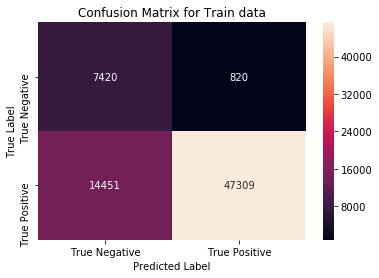

In [22]:
class_label = ["True Negative", "True Positive"]
cm=pd.DataFrame(confusion_matrix(Y_train,dt.predict(bow_train)),index=class_label,columns=class_label)
sns.heatmap(cm,annot=True,fmt="g")
plt.title("Confusion Matrix for Train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

In [23]:
from sklearn.metrics import classification_report

In [24]:
print(classification_report(Y_test,dt.predict(bow_test)))

              precision    recall  f1-score   support

           0       0.32      0.76      0.45      4146
           1       0.95      0.74      0.83     25854

   micro avg       0.74      0.74      0.74     30000
   macro avg       0.63      0.75      0.64     30000
weighted avg       0.86      0.74      0.78     30000



### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [28]:
# Please write all the code with proper documentation

In [25]:
# https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    #print(len(feature_names))
    #print(clf.n_features_)
    coefs_with_fns = sorted(zip(clf.feature_importances_, feature_names))
    top =  coefs_with_fns[:-(n + 1):-1]
    for  (coef_2, fn_2) in top:
        print(coef_2, fn_2)
print("Top 10 important features of positive class" )
show_most_informative_features(vec, dt)

Top 10 important features of positive class
0.13989438279300737 not
0.09504359836263038 great
0.05772867184855182 best
0.0371940176999842 delicious
0.02544430899000769 love
0.02535229873477603 good
0.02396600205379414 perfect
0.02070048001558019 loves
0.018692091820600852 disappointed
0.018148443992371324 wonderful
0.0170120201819959 favorite
0.015800849182718565 excellent
0.014198705455909956 bad
0.012590530149643075 tasty
0.012538892331641713 money
0.012281895096188482 nice
0.011784524174207413 highly
0.010707806083410659 thought
0.010104079190465371 awful
0.009301294710491632 would
0.009089857361160128 terrible
0.008441391719610144 find
0.008280857611780861 easy
0.007743771599858929 however
0.007501826399567137 always


### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

In [40]:
# Please write all the code with proper documentation

In [29]:
dt= DecisionTreeClassifier(max_depth=3,min_samples_split=500,class_weight='balanced')
dt.fit(bow_train, Y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [ ]:
#Make sure to print the words in each node of the decision tree instead of printing its index.

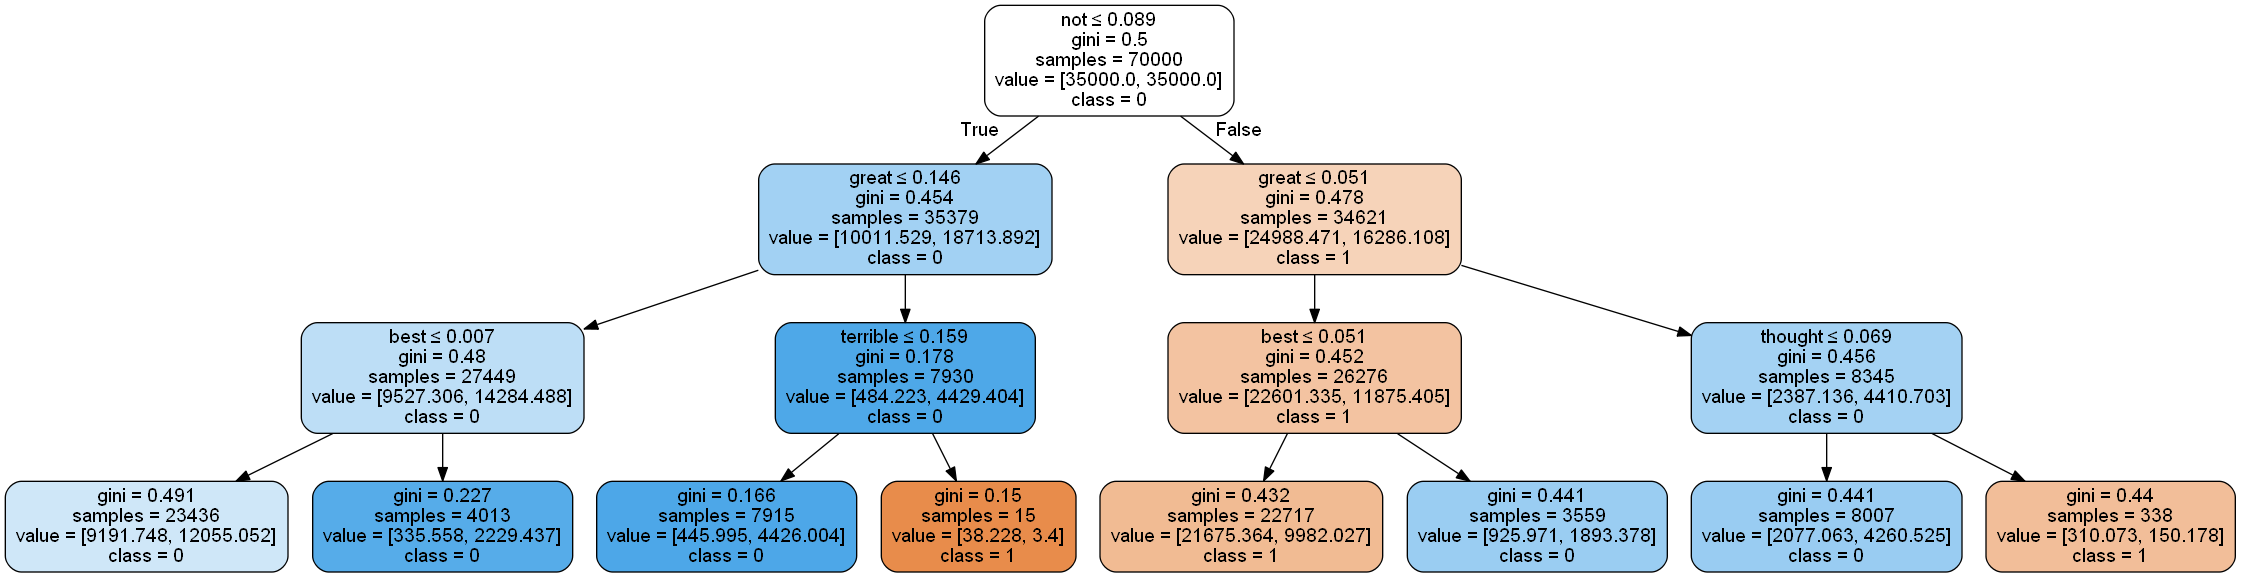

In [34]:
from sklearn import tree
import pydotplus
from IPython.display import Image
from graphviz import Source

target=['1','0']
data = tree.export_graphviz(dt,out_file=None,class_names=target,filled=True,rounded=True,special_characters=True,feature_names=vec.get_feature_names())
graph = pydotplus.graph_from_dot_data(data)
Image(graph.create_png())

## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

In [35]:
tfidf= TfidfVectorizer(ngram_range=(1,2))
tfidf_train = tfidf.fit_transform(X_train)
tfidf_test = tfidf.transform(X_test)

#normalize the data 
from sklearn import preprocessing
tfidf_train = preprocessing.normalize(tfidf_train)
tfidf_test = preprocessing.normalize(tfidf_test)


In [36]:
print("After Vectorization")
print(tfidf_train.shape,Y_train.shape)
print(tfidf_test.shape,Y_test.shape)


After Vectorization
(70000, 1127501) (70000,)
(30000, 1127501) (30000,)


In [37]:
dt= DecisionTreeClassifier(class_weight='balanced')
#we will create a dictonary of values using which we will test for n_neighbors
depths=[1, 5, 10, 50, 100, 500, 100]
split=[5, 10, 100, 500]
para_grid= {'max_depth':depths, 'min_samples_split':split}
#We will use the gridsearch to test all aforementioned values for alpha
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
ts_cv = TimeSeriesSplit(n_splits =10)
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
dt_tfidf= GridSearchCV(dt,para_grid,cv=ts_cv,scoring='roc_auc',n_jobs=-1)
#we will be fitting the optimised k values to the train_bow data
dt_tfidf.fit(tfidf_train,Y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [1, 5, 10, 50, 100, 500, 100], 'min_samples_split': [5, 10, 100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [38]:
#The best C value obtained from the gridsearchCV is 
best_para= dt_tfidf.best_params_
print("Best  Hyperparameter:", best_para)
print("The accuracy obtained by using the hyperparameter is:",dt_tfidf.best_score_*100)


Best  Hyperparameter: {'max_depth': 50, 'min_samples_split': 500}
The accuracy obtained by using the hyperparameter is: 77.45619339093511


In [39]:
keys = dt_tfidf.cv_results_['params']
key=[]
for i in keys:
    key.append(str(i))
print(key)

["{'max_depth': 1, 'min_samples_split': 5}", "{'max_depth': 1, 'min_samples_split': 10}", "{'max_depth': 1, 'min_samples_split': 100}", "{'max_depth': 1, 'min_samples_split': 500}", "{'max_depth': 5, 'min_samples_split': 5}", "{'max_depth': 5, 'min_samples_split': 10}", "{'max_depth': 5, 'min_samples_split': 100}", "{'max_depth': 5, 'min_samples_split': 500}", "{'max_depth': 10, 'min_samples_split': 5}", "{'max_depth': 10, 'min_samples_split': 10}", "{'max_depth': 10, 'min_samples_split': 100}", "{'max_depth': 10, 'min_samples_split': 500}", "{'max_depth': 50, 'min_samples_split': 5}", "{'max_depth': 50, 'min_samples_split': 10}", "{'max_depth': 50, 'min_samples_split': 100}", "{'max_depth': 50, 'min_samples_split': 500}", "{'max_depth': 100, 'min_samples_split': 5}", "{'max_depth': 100, 'min_samples_split': 10}", "{'max_depth': 100, 'min_samples_split': 100}", "{'max_depth': 100, 'min_samples_split': 500}", "{'max_depth': 500, 'min_samples_split': 5}", "{'max_depth': 500, 'min_samples

[0.62675552 0.62675552 0.62675552 0.62675552 0.75582383 0.75562851
 0.75443504 0.75189494 0.84052129 0.83837226 0.82744128 0.8157883
 0.97608309 0.97042359 0.94805277 0.91886261 0.99111257 0.98772277
 0.97007905 0.93804982 0.9998923  0.99912169 0.98806338 0.95563402
 0.99143899 0.98784845 0.97013295 0.93823282]


Text(0.5, 1.0, 'Error Plot')

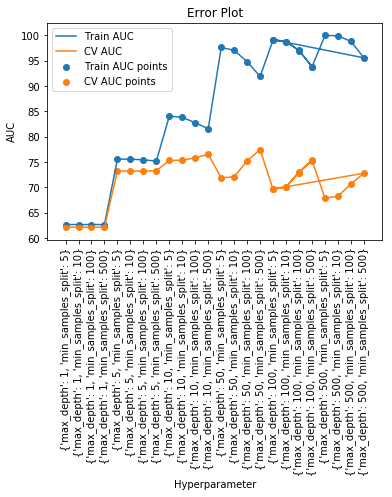

In [40]:
train_auc = dt_tfidf.cv_results_['mean_train_score']
cv_auc = dt_tfidf.cv_results_['mean_test_score']
print(train_auc)
plt.plot(key,train_auc*100,label='Train AUC')
plt.plot(key,cv_auc*100,label='CV AUC')
plt.scatter(key,train_auc*100,label='Train AUC points')
plt.scatter(key,cv_auc*100,label='CV AUC points')
plt.xticks(rotation=90)
plt.legend()
plt.xlabel('Hyperparameter')
plt.ylabel('AUC')
plt.title('Error Plot')



In [41]:
#we will select the best hyperparameter and train the model using the parameter

dt= DecisionTreeClassifier(max_depth=50,min_samples_split=500,class_weight='balanced')
dt.fit(tfidf_train, Y_train)
y_train_pred= dt.predict_proba(tfidf_train)[:,1]
y_test_pred=dt.predict_proba(tfidf_test)[:,1]

In [42]:
train_fpr,train_tpr,thersholds=roc_curve(Y_train,y_train_pred)
test_fpr,test_tpr,thersholds=roc_curve(Y_test,y_test_pred)

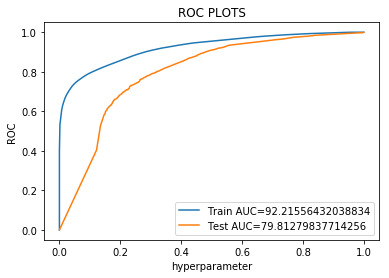

In [43]:
plt.plot(train_fpr,train_tpr,label="Train AUC=" +str(auc(train_fpr,train_tpr)*100))
plt.plot(test_fpr,test_tpr,label="Test AUC=" +str(auc(test_fpr,test_tpr)*100))
plt.xlabel("hyperparameter")
plt.ylabel("ROC")
plt.title("ROC PLOTS")
plt.legend()
plt.legend()

Text(33.0, 0.5, 'True Label')

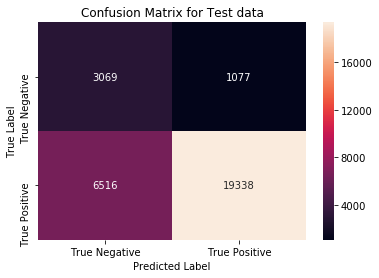

In [44]:
class_label = ["True Negative", "True Positive"]
cm=pd.DataFrame(confusion_matrix(Y_test,dt.predict(tfidf_test)),index=class_label,columns=class_label)
sns.heatmap(cm,annot=True,fmt="g")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

Text(33.0, 0.5, 'True Label')

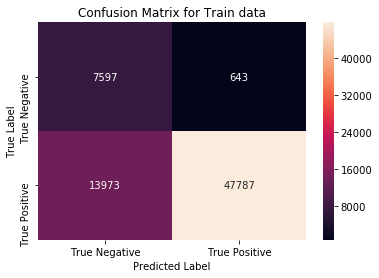

In [45]:
class_label = ["True Negative", "True Positive"]
cm=pd.DataFrame(confusion_matrix(Y_train,dt.predict(tfidf_train)),index=class_label,columns=class_label)
sns.heatmap(cm,annot=True,fmt="g")
plt.title("Confusion Matrix for Train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

In [46]:
print(classification_report(Y_test,dt.predict(tfidf_test)))

              precision    recall  f1-score   support

           0       0.32      0.74      0.45      4146
           1       0.95      0.75      0.84     25854

   micro avg       0.75      0.75      0.75     30000
   macro avg       0.63      0.74      0.64     30000
weighted avg       0.86      0.75      0.78     30000



### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

In [47]:
# Please write all the code with proper documentation

In [49]:
# https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    #print(len(feature_names))
    #print(clf.n_features_)
    coefs_with_fns = sorted(zip(clf.feature_importances_, feature_names))
    top =  coefs_with_fns[:-(n + 1):-1]
    for  (coef_2, fn_2) in top:
        print(coef_2, fn_2)
print("Top 25 important features " )
show_most_informative_features(tfidf, dt)

Top 25 important features 
0.12079503639142537 not
0.09259617380750958 great
0.053379407306585594 best
0.03614877160103533 delicious
0.026695356260243344 good
0.02436642493731266 perfect
0.023386850748702177 love
0.019715653279412465 loves
0.01791594513652329 disappointed
0.01711300999014711 favorite
0.01657469047829021 wonderful
0.01580626887829129 bad
0.015754588873830543 excellent
0.011871634010426164 nice
0.011032239269313512 money
0.010151290027228489 would
0.01001695213087334 tasty
0.008891032577647949 terrible
0.008404701415376513 thought
0.008234095260991114 always
0.007838677435808749 awful
0.00755221382755991 highly
0.007426153948358233 easy
0.006856542892844456 find
0.006716390148131299 product


### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

In [51]:

dt= DecisionTreeClassifier(max_depth=3,min_samples_split=500,class_weight='balanced')
dt.fit(tfidf_train, Y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

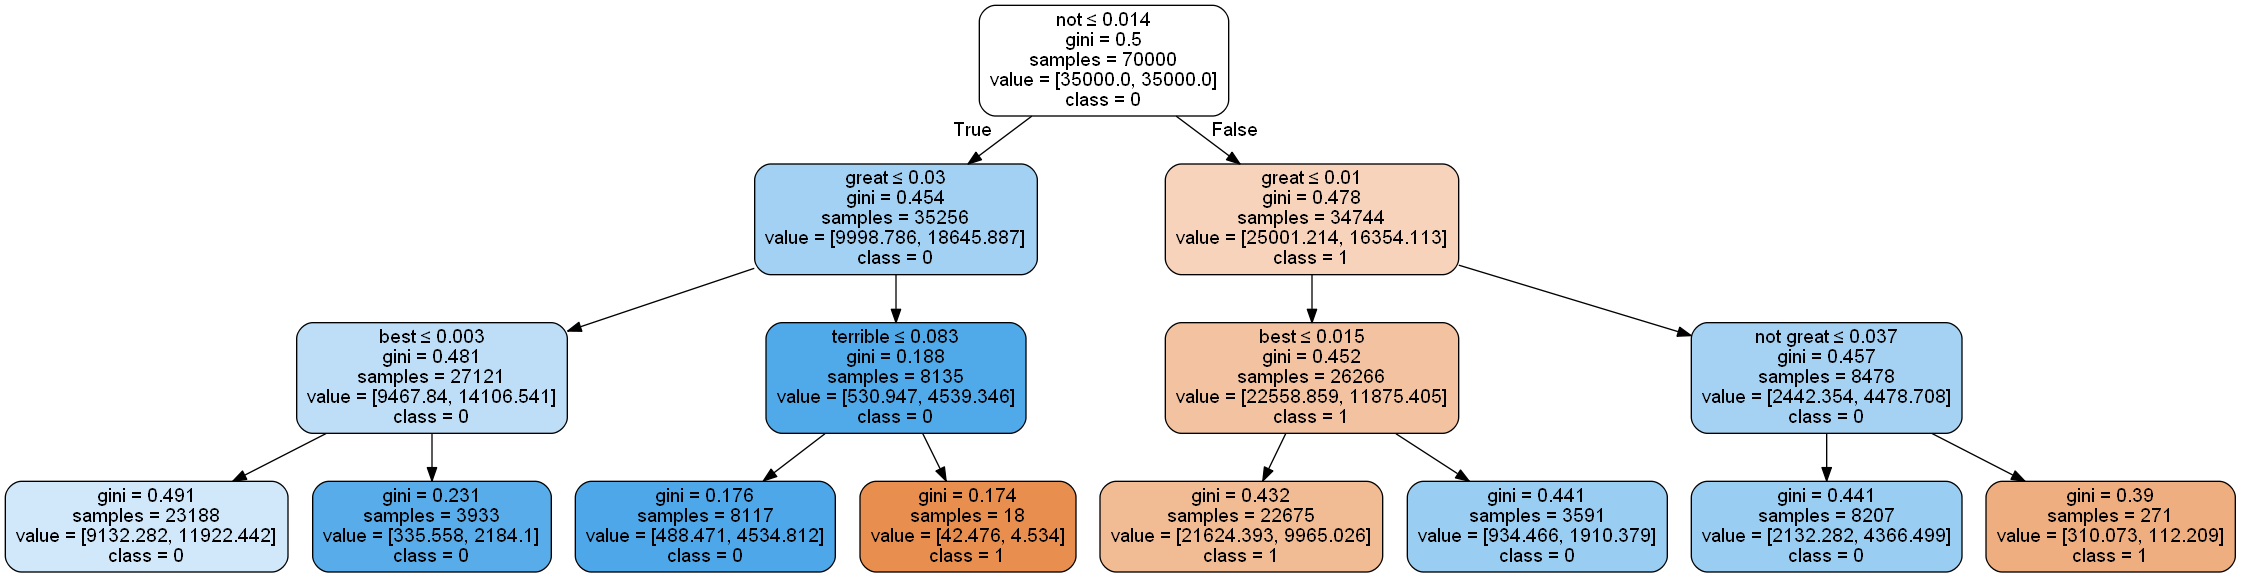

In [53]:
#https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html

from sklearn import tree
import pydotplus
from IPython.display import Image
from graphviz import Source

target=['1','0']
data = tree.export_graphviz(dt,out_file=None,class_names=target,filled=True,rounded=True,special_characters=True,feature_names=tfidf.get_feature_names())
graph = pydotplus.graph_from_dot_data(data)
Image(graph.create_png())

## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation

In [188]:
# Train your own Word2Vec model using your own text corpus
i=0
sentance_train=[]
for sentance in X_train:
    sentance_train.append(sentance.split())

In [189]:
# to train the W2V model on the provided list of sentences
w2v_model=Word2Vec(sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  15972
sample words  ['witty', 'little', 'book', 'makes', 'son', 'laugh', 'loud', 'car', 'driving', 'along', 'always', 'sing', 'refrain', 'learned', 'india', 'roses', 'love', 'new', 'words', 'introduces', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'remember', 'seeing', 'show', 'television', 'years', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirty', 'something', 'used', 'series', 'books', 'songs', 'student', 'teaching', 'turned', 'whole', 'school', 'purchasing']


In [190]:
# we will convert the test data into W2V
# average Word2Vec
# compute average word2vec for each review.
vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    vectors_train.append(sent_vec)
print(len(vectors_train))
print(len(vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 70000/70000 [02:18<00:00, 506.96it/s]


70000
50


In [191]:
# Converting the test data text
i=0
sentance_test=[]
for sentance in X_test:
    sentance_test.append(sentance.split())

In [192]:
# we will convert the test data into W2V
# average Word2Vec
# compute average word2vec for each review.
vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    vectors_test.append(sent_vec)
print(len(vectors_test))
print(len(vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [01:00<00:00, 495.69it/s]


30000
50


In [193]:
dt= DecisionTreeClassifier(class_weight='balanced')
#we will create a dictonary of values using which we will test for n_neighbors
depths=[1, 5, 10, 50, 100, 500, 100]
split=[5, 10, 100, 500]
para_grid= {'max_depth':depths, 'min_samples_split':split}
#We will use the gridsearch to test all aforementioned values for alpha
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
ts_cv = TimeSeriesSplit(n_splits =10)
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
dt_avg= GridSearchCV(dt,para_grid,cv=ts_cv,scoring='roc_auc',n_jobs=-1)
#we will be fitting the optimised k values to the train_bow data
dt_avg.fit(vectors_train,Y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [1, 5, 10, 50, 100, 500, 100], 'min_samples_split': [5, 10, 100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [194]:
#The best C value obtained from the gridsearchCV is 
best_para= dt_avg.best_params_
print("Best  Hyperparameter:", best_para)
print("The accuracy obtained by using the hyperparameter is:",dt_avg.best_score_*100)


Best  Hyperparameter: {'max_depth': 10, 'min_samples_split': 500}
The accuracy obtained by using the hyperparameter is: 79.6625246455129


In [195]:
keys = dt_avg.cv_results_['params']
key=[]
for i in keys:
    key.append(str(i))
print(key)

["{'max_depth': 1, 'min_samples_split': 5}", "{'max_depth': 1, 'min_samples_split': 10}", "{'max_depth': 1, 'min_samples_split': 100}", "{'max_depth': 1, 'min_samples_split': 500}", "{'max_depth': 5, 'min_samples_split': 5}", "{'max_depth': 5, 'min_samples_split': 10}", "{'max_depth': 5, 'min_samples_split': 100}", "{'max_depth': 5, 'min_samples_split': 500}", "{'max_depth': 10, 'min_samples_split': 5}", "{'max_depth': 10, 'min_samples_split': 10}", "{'max_depth': 10, 'min_samples_split': 100}", "{'max_depth': 10, 'min_samples_split': 500}", "{'max_depth': 50, 'min_samples_split': 5}", "{'max_depth': 50, 'min_samples_split': 10}", "{'max_depth': 50, 'min_samples_split': 100}", "{'max_depth': 50, 'min_samples_split': 500}", "{'max_depth': 100, 'min_samples_split': 5}", "{'max_depth': 100, 'min_samples_split': 10}", "{'max_depth': 100, 'min_samples_split': 100}", "{'max_depth': 100, 'min_samples_split': 500}", "{'max_depth': 500, 'min_samples_split': 5}", "{'max_depth': 500, 'min_samples

[0.63578915 0.63578915 0.63578915 0.63578915 0.81511838 0.81507317
 0.8139834  0.81174884 0.93360425 0.93116479 0.90751877 0.85870105
 0.99981823 0.99828204 0.93802261 0.86141381 0.99982911 0.99829759
 0.9380272  0.86141381 0.99983153 0.99830219 0.93804888 0.8614137
 0.99983041 0.99828281 0.938014   0.86141321]


Text(0.5, 1.0, 'Error Plot')

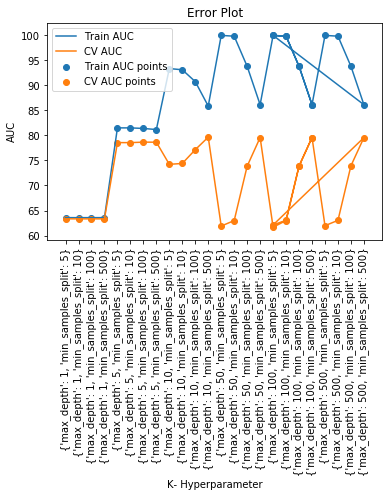

In [196]:
train_auc = dt_avg.cv_results_['mean_train_score']
cv_auc = dt_avg.cv_results_['mean_test_score']
print(train_auc)
plt.plot(key,train_auc*100,label='Train AUC')
plt.plot(key,cv_auc*100,label='CV AUC')
plt.scatter(key,train_auc*100,label='Train AUC points')
plt.scatter(key,cv_auc*100,label='CV AUC points')
plt.xticks(rotation=90)
plt.legend()
plt.xlabel('K- Hyperparameter')
plt.ylabel('AUC')
plt.title('Error Plot')



In [198]:
#we will select the best hyperparameter and train the model using the parameter

dt= DecisionTreeClassifier(max_depth=10,min_samples_split=500,class_weight='balanced')
dt.fit(vectors_train, Y_train)
y_train_pred= dt.predict_proba(vectors_train)[:,1]
y_test_pred=dt.predict_proba(vectors_test)[:,1]

In [199]:
train_fpr,train_tpr,thersholds=roc_curve(Y_train,y_train_pred)
test_fpr,test_tpr,thersholds=roc_curve(Y_test,y_test_pred)

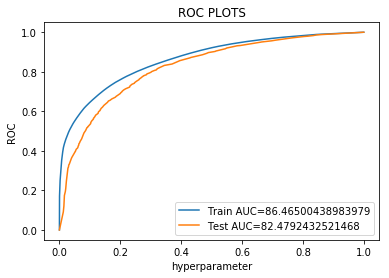

In [200]:
plt.plot(train_fpr,train_tpr,label="Train AUC=" +str(auc(train_fpr,train_tpr)*100))
plt.plot(test_fpr,test_tpr,label="Test AUC=" +str(auc(test_fpr,test_tpr)*100))
plt.xlabel("hyperparameter")
plt.ylabel("ROC")
plt.title("ROC PLOTS")
plt.legend()
plt.legend()

Text(33.0, 0.5, 'True Label')

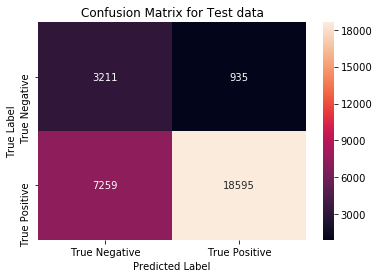

In [201]:
class_label = ["True Negative", "True Positive"]
cm=pd.DataFrame(confusion_matrix(Y_test,dt.predict(vectors_test)),index=class_label,columns=class_label)
sns.heatmap(cm,annot=True,fmt="g")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

Text(33.0, 0.5, 'True Label')

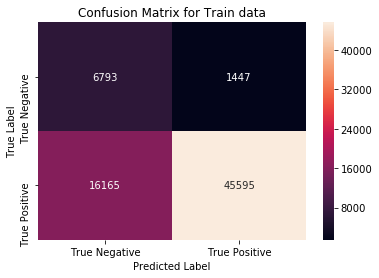

In [202]:
class_label = ["True Negative", "True Positive"]
cm=pd.DataFrame(confusion_matrix(Y_train,dt.predict(vectors_train)),index=class_label,columns=class_label)
sns.heatmap(cm,annot=True,fmt="g")
plt.title("Confusion Matrix for Train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

In [203]:
print(classification_report(Y_test,dt.predict(vectors_test)))

              precision    recall  f1-score   support

           0       0.31      0.77      0.44      4146
           1       0.95      0.72      0.82     25854

   micro avg       0.73      0.73      0.73     30000
   macro avg       0.63      0.75      0.63     30000
weighted avg       0.86      0.73      0.77     30000



## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

In [204]:
# Please write all the code with proper documentation

In [205]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [206]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 70000/70000 [29:29<00:00, 39.57it/s]


In [207]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [13:16<00:00, 37.67it/s]


In [208]:
dt= DecisionTreeClassifier(class_weight='balanced')
#we will create a dictonary of values using which we will test for n_neighbors
depths=[1, 5, 10, 50, 100, 500, 100]
split=[5, 10, 100, 500]
para_grid= {'max_depth':depths, 'min_samples_split':split}
#We will use the gridsearch to test all aforementioned values for alpha
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
ts_cv = TimeSeriesSplit(n_splits =10)
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
dt_w2v= GridSearchCV(dt,para_grid,cv=ts_cv,scoring='roc_auc',n_jobs=-1)
#we will be fitting the optimised k values to the train_bow data
dt_w2v.fit(tfidf_sent_vectors,Y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [1, 5, 10, 50, 100, 500, 100], 'min_samples_split': [5, 10, 100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [209]:
#The best C value obtained from the gridsearchCV is 
best_para= dt_w2v.best_params_
print("Best  Hyperparameter:", best_para)
print("The accuracy obtained by using the hyperparameter is:",dt_w2v.best_score_*100)


Best  Hyperparameter: {'max_depth': 10, 'min_samples_split': 500}
The accuracy obtained by using the hyperparameter is: 76.41988963443261


In [210]:
keys = dt_w2v.cv_results_['params']
key=[]
for i in keys:
    key.append(str(i))
print(key)

["{'max_depth': 1, 'min_samples_split': 5}", "{'max_depth': 1, 'min_samples_split': 10}", "{'max_depth': 1, 'min_samples_split': 100}", "{'max_depth': 1, 'min_samples_split': 500}", "{'max_depth': 5, 'min_samples_split': 5}", "{'max_depth': 5, 'min_samples_split': 10}", "{'max_depth': 5, 'min_samples_split': 100}", "{'max_depth': 5, 'min_samples_split': 500}", "{'max_depth': 10, 'min_samples_split': 5}", "{'max_depth': 10, 'min_samples_split': 10}", "{'max_depth': 10, 'min_samples_split': 100}", "{'max_depth': 10, 'min_samples_split': 500}", "{'max_depth': 50, 'min_samples_split': 5}", "{'max_depth': 50, 'min_samples_split': 10}", "{'max_depth': 50, 'min_samples_split': 100}", "{'max_depth': 50, 'min_samples_split': 500}", "{'max_depth': 100, 'min_samples_split': 5}", "{'max_depth': 100, 'min_samples_split': 10}", "{'max_depth': 100, 'min_samples_split': 100}", "{'max_depth': 100, 'min_samples_split': 500}", "{'max_depth': 500, 'min_samples_split': 5}", "{'max_depth': 500, 'min_samples

[0.61248004 0.61248004 0.61248004 0.61248004 0.78900747 0.78900747
 0.7888146  0.7840706  0.92453035 0.92227868 0.89454222 0.8357036
 0.99981514 0.99816495 0.92864905 0.83916719 0.99981382 0.99818786
 0.92865878 0.83917484 0.99981624 0.99815361 0.92868579 0.8391473
 0.99981678 0.99819734 0.92879394 0.83914735]


Text(0.5, 1.0, 'Error Plot')

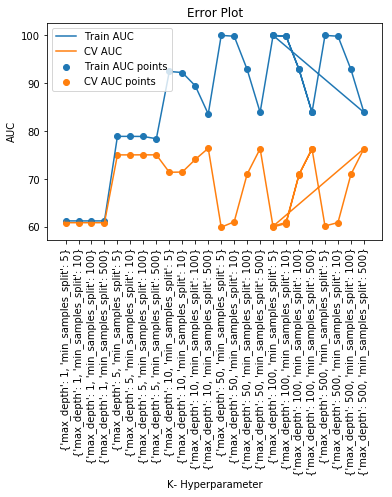

In [211]:
train_auc = dt_w2v.cv_results_['mean_train_score']
cv_auc = dt_w2v.cv_results_['mean_test_score']
print(train_auc)
plt.plot(key,train_auc*100,label='Train AUC')
plt.plot(key,cv_auc*100,label='CV AUC')
plt.scatter(key,train_auc*100,label='Train AUC points')
plt.scatter(key,cv_auc*100,label='CV AUC points')
plt.xticks(rotation=90)
plt.legend()
plt.xlabel('K- Hyperparameter')
plt.ylabel('AUC')
plt.title('Error Plot')



In [213]:
#we will select the best hyperparameter and train the model using the parameter

dt= DecisionTreeClassifier(max_depth=10,min_samples_split=500,class_weight='balanced')
dt.fit(tfidf_sent_vectors, Y_train)
y_train_pred= dt.predict_proba(tfidf_sent_vectors)[:,1]
y_test_pred=dt.predict_proba(tfidf_sent_vectors_test)[:,1]

In [214]:
train_fpr,train_tpr,thersholds=roc_curve(Y_train,y_train_pred)
test_fpr,test_tpr,thersholds=roc_curve(Y_test,y_test_pred)

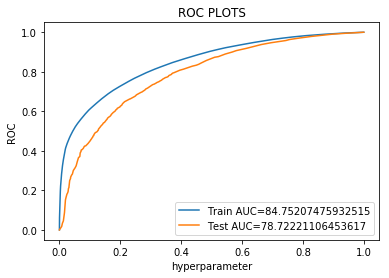

In [215]:
plt.plot(train_fpr,train_tpr,label="Train AUC=" +str(auc(train_fpr,train_tpr)*100))
plt.plot(test_fpr,test_tpr,label="Test AUC=" +str(auc(test_fpr,test_tpr)*100))
plt.xlabel("hyperparameter")
plt.ylabel("ROC")
plt.title("ROC PLOTS")
plt.legend()
plt.legend()

Text(33.0, 0.5, 'True Label')

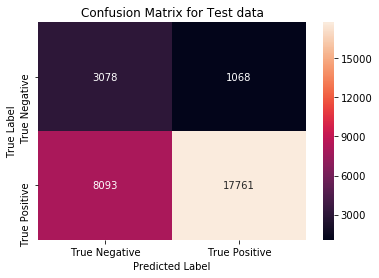

In [216]:
class_label = ["True Negative", "True Positive"]
cm=pd.DataFrame(confusion_matrix(Y_test,dt.predict(tfidf_sent_vectors_test)),index=class_label,columns=class_label)
sns.heatmap(cm,annot=True,fmt="g")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

Text(33.0, 0.5, 'True Label')

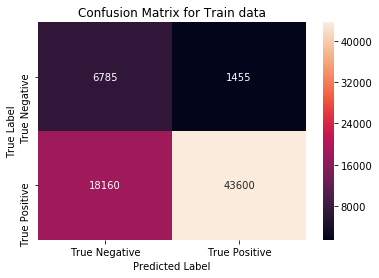

In [217]:
class_label = ["True Negative", "True Positive"]
cm=pd.DataFrame(confusion_matrix(Y_train,dt.predict(tfidf_sent_vectors)),index=class_label,columns=class_label)
sns.heatmap(cm,annot=True,fmt="g")
plt.title("Confusion Matrix for Train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# [6] Conclusions

In [0]:
# Please compare all your models using Prettytable library

In [54]:
from prettytable import PrettyTable
    
tab = PrettyTable()

In [55]:
tab.field_names = ["Vectorizer", "max_depth", "min_samples_split", "AUC"]

tab.add_row(["BOW", 50,500, 80.37])
tab.add_row(["TFIDF",50, 500, 79.81])
tab.add_row(["AVG W2V", 10, 500, 82.47])
tab.add_row(["TFIDFW2V",10, 500, 78.72])


In [56]:
print(tab)

+------------+-----------+-------------------+-------+
| Vectorizer | max_depth | min_samples_split |  AUC  |
+------------+-----------+-------------------+-------+
|    BOW     |     50    |        500        | 80.37 |
|   TFIDF    |     50    |        500        | 79.81 |
|  AVG W2V   |     10    |        500        | 82.47 |
|  TFIDFW2V  |     10    |        500        | 78.72 |
+------------+-----------+-------------------+-------+


# Observations

1. Used all four vectorizer and optmised the max depth, min_sample_split using Gridsearch CV.
2. Plotted the Decsion tree for BOW, TFIDF vectoriser using the depth to be 3. 
3. The highest accuracy on test data obtained was 82.47% using Average W2V.
4. The recall is quite high for class '0' in all four vectoriser.
